# Preprocessing and reading in train - and test dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from datetime import timedelta
import glob
import os
from tqdm import tqdm as tqdm
import time
import seaborn as sns

%matplotlib inline
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

from numpy import cumsum
from datetime import datetime as dt

In [ ]:
data_path = input("Enter the path to the data folder: ")

In [4]:
Train = pd.read_csv(str(data_path) + "\\train_count_street_data.csv")
Train.drop("Unnamed: 0", axis=1, inplace=True)

TestCovid = pd.read_csv(data_path + "\\test_covid_count_street_data.csv")
TestCovid.drop("Unnamed: 0", axis=1, inplace=True)

TestNoCovid = pd.read_csv(data_path + "\\test_no_covid_count_street_data.csv")
TestNoCovid.drop("Unnamed: 0", axis=1, inplace=True)

TrainWithNoCovid = pd.read_csv(data_path + "\\train_with_no_covid_count_street_data.csv")
TrainWithNoCovid.drop("Unnamed: 0", axis=1, inplace=True)

# Building a multivariate linear regression model

In [5]:
# X_train = Train[['Year', 'Month', 'MSOA', 'Crime type']]
# X_train = pd.concat([X_train,pd.get_dummies(X_train['Crime type'])],axis=1)
# X_train.drop(['Crime type'],axis=1, inplace=True)

# y_train = Train['count']

# X_test = TestNoCovid[['Year', 'Month', 'MSOA', 'Crime type']]
# X_test = pd.concat([X_test,pd.get_dummies(X_test['Crime type'])],axis=1)
# X_test.drop(['Crime type'],axis=1, inplace=True)

# y_test = TestNoCovid['count']

# # Creating a new model and fitting it
# multi_model = LinearRegression()
# multi_model.fit(X_train, y_train)

# # Prediction new values
# predictions = multi_model.predict(X_test)
# r2 = r2_score(y_test, predictions)
# rmse = mean_squared_error(y_test, predictions, squared=False)

# print('The r2 is: ', r2)
# print('The rmse is: ', rmse)

In [6]:
# multi_model.coef_

# Arima

In ARIMA_OPTIMAL there has to be the 'd' added as hyperparameter looping. Furthermore, there has to get a bugfix for when optimum returns more than 1 row. (MSE instead of AIC?)

In [7]:
def ARIMA_DATA(df, MSOA, category):
    ###Gets the data of a specific MSOA and category to use in the ARIMA_OPTIMAL function
    ###
    
    df = df[(df['MSOA'] == int(MSOA)) & (df['Crime type'] == category)]
    df = df[['Date', 'count']]
    df = df.set_index('Date')
    
    return df

def ARIMA_STATIONARY(df):
    ###Returns a stationary dataframe, created by ARIMA_DATA
    ###
    if adfuller(df['count'])[1] > 0.05:
        df = df.diff().dropna()
    
    return df

def ARIMA_OPTIMAL(stationary_data, MSOA, category):
    ### Looks for the best ARMA(p,q) + constant model according to MSOA and crime type
    ###
    
    order_aic_bic = list()

    # Loop over AR order
    for p in range(1,4):
        # Loop over MA order
        for q in range(1,4):
            #for d in range(3):
            try:
            # Fit model
                model = SARIMAX(stationary_data, order=(p,0,q), trend='c')
                results = model.fit()
                # Add order and scores to list
                order_aic_bic.append((p, q, results.aic))
            except:
                continue
            
    order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic'])
    optimum = order_df[order_df['aic'] == order_df['aic'].min()]
    optimum.reset_index(inplace=True)
    return optimum['p'][0], optimum['q'][0], optimum['aic'][0]

def ARIMA_PREDICT(df, MSOA, category):
    ###Forecasts via ARIMA approach
    ###
    
    arima_data = ARIMA_DATA(df, MSOA, category)
    stationary_data = ARIMA_STATIONARY(arima_data)
    
    p,q = ARIMA_OPTIMAL(stationary_data, MSOA, category)[0:2]
    
    model = SARIMAX(stationary_data, order=(p,0,q), trend='c')
    results = model.fit()
    forecast = results.get_prediction(start=-25)
    mean_forecast = cumsum(forecast.predicted_mean) + stationary_data.iloc[-1,0]
    confidence_intervals = cumsum(forecast.conf_int())
    return arima_data, mean_forecast.to_frame(), confidence_intervals

def ARIMA_SUMMARY(df, MSOA, category):
    
    stationary_data = ARIMA_STATIONARY(ARIMA_DATA(df, MSOA, category))
    
    p,q = ARIMA_OPTIMAL(stationary_data, MSOA, category)[0:2]
    
    model = SARIMAX(stationary_data, order=(p,0,q), trend='c')
    results = model.fit()
    
    return results.summary()

def model_predict(df, msoa, category):
    data, mean_forecasts, confidence_intervals = ARIMA_PREDICT(df, msoa, category)
    
    lower_limits = confidence_intervals['lower count']
    upper_limits = confidence_intervals['upper count']
    
    return data, mean_forecasts, confidence_intervals, lower_limits, upper_limits

def get_best_models(df):
    param = list()
    
    for MSOA in tqdm(df['MSOA'].unique()):
        for category in df['Crime type'].unique():
            arima_data = ARIMA_DATA(df, MSOA, category)
            stationary_data = ARIMA_STATIONARY(arima_data)
            p, q, aic = ARIMA_OPTIMAL(stationary_data, MSOA, category)
            param.append((MSOA, category, p, q, aic))
            
    return pd.DataFrame(param, columns=['MSOA', 'Crime type', 'p','q', 'aic'])

In [8]:
#print(ARIMA_SUMMARY(Train, '099', 'Anti-social behaviour'))

In [9]:
# data = ARIMA_DATA(Train, '099', 'Anti-social behaviour')
# mean_forecasts = ARIMA_PREDICT(Train, '099', 'Anti-social behaviour')[0].to_frame()
# confidence_intervals = ARIMA_PREDICT(Train, '099', 'Anti-social behaviour')[1]
# lower_limits = confidence_intervals['lower count']
# upper_limits = confidence_intervals['upper count']

In [10]:
data, mean_forecasts, confidence_intervals, lower_limits, upper_limits = model_predict(Train, '099', 'Anti-social behaviour')

In [ ]:
best_models = get_best_models(Train)
best_models

In [ ]:
best_models.to_csv("train_best_models.csv")

In [ ]:
best_models_train_with_no_covid = get_best_models(TrainWithNoCovid)
best_models_train_with_no_covid

In [ ]:
best_models_train_with_no_covid.to_csv("train_with_no_covid_best_models.csv")

In [11]:
print(ARIMA_SUMMARY(Train, '099', 'Anti-social behaviour'))

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   83
Model:               SARIMAX(3, 0, 3)   Log Likelihood                -302.513
Date:                Thu, 31 Mar 2022   AIC                            621.027
Time:                        15:33:27   BIC                            640.378
Sample:                    02-01-2012   HQIC                           628.801
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3216      0.159     -2.019      0.043      -0.634      -0.009
ar.L1         -0.5810      0.153     -3.789      0.000      -0.882      -0.281
ar.L2         -0.6004      0.144     -4.161      0.0

In [12]:
test = mean_forecasts.reset_index()
test['Date'] = test['index'].dt.strftime('%Y-%m')
test.drop(columns=['index'], inplace=True, axis=1)
test.set_index('Date', inplace=True)
test = test.rename(columns={0:'predicted_mean'})
test_2 = test.copy()
test

,predicted_mean
Date,
2016-12,11.855961
2017-01,28.421856
2017-02,16.552574
2017-03,20.460201
2017-04,18.647134
2017-05,8.779552
2017-06,13.842833
2017-07,19.633676
2017-08,12.830440


In [13]:
# fig = data.plot(figsize=(7,4))
# fig2 = test.plot(ax=fig)
# # fig2.legend(['count', 'forecasted']);
# fig

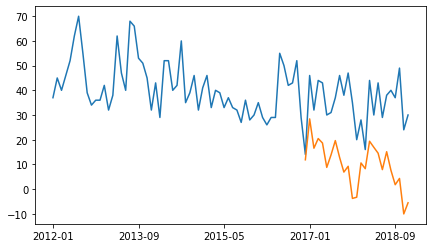

In [14]:
plot_data = pd.concat([data, test], axis=1)
fig_plot = plot_data['count'].plot(figsize=(7,4))
plot_data['predicted_mean'].plot(ax=fig_plot)
# fig2.legend(['count', 'forecasted']);
fig_plot;

In [15]:
print(plot_data.to_string())

         count  predicted_mean
2012-01     37             NaN
2012-02     45             NaN
2012-03     40             NaN
2012-04     46             NaN
2012-05     52             NaN
2012-06     62             NaN
2012-07     70             NaN
2012-08     55             NaN
2012-09     39             NaN
2012-10     34             NaN
2012-11     36             NaN
2012-12     36             NaN
2013-01     42             NaN
2013-02     32             NaN
2013-03     38             NaN
2013-04     62             NaN
2013-05     47             NaN
2013-06     40             NaN
2013-07     68             NaN
2013-08     66             NaN
2013-09     53             NaN
2013-10     51             NaN
2013-11     45             NaN
2013-12     32             NaN
2014-01     43             NaN
2014-02     29             NaN
2014-03     52             NaN
2014-04     52             NaN
2014-05     40             NaN
2014-06     42             NaN
2014-07     60             NaN
2014-08 

### Inverted predictions (wrong?)

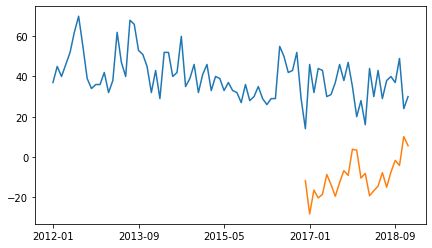

In [16]:
test_2['predicted_mean'] *= -1
plot_data_2 = pd.concat([data, test_2], axis=1)
fig_plot_2 = plot_data_2['count'].plot(figsize=(7,4))
plot_data_2['predicted_mean'].plot(ax=fig_plot_2)
# fig2.legend(['count', 'forecasted']);
fig_plot_2;

In [17]:
#Train['Crime type'].unique()